# **Logistic Regression**

# Import libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import json
import re
import string
import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load and prepare data

> This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api 
> The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment.


In [27]:
columns = ["label", "ids", "date", "flag", "user", "text"]
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', \
                 encoding='ISO-8859-1', names=columns)

# Exploring the data

In [28]:
df.head(-5)

,label,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599990,4,2193579249,Tue Jun 16 08:38:59 PDT 2009,NO_QUERY,razzberry5594,WOOOOO! Xbox is back
1599991,4,2193579284,Tue Jun 16 08:38:59 PDT 2009,NO_QUERY,AgustinaP,@rmedina @LaTati Mmmm That sounds absolutely ...
1599992,4,2193579434,Tue Jun 16 08:39:00 PDT 2009,NO_QUERY,sdancingsteph,ReCoVeRiNg FrOm ThE lOnG wEeKeNd
1599993,4,2193579477,Tue Jun 16 08:39:00 PDT 2009,NO_QUERY,ChloeAmisha,@SCOOBY_GRITBOYS


In [29]:
#handle labels of positive tweets 4 >> 1
df['label'] = df['label'].replace(4,1)

In [30]:
df.shape

(1600000, 6)

In [31]:
df.isnull().sum()

label    0
ids      0
date     0
flag     0
user     0
text     0
dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

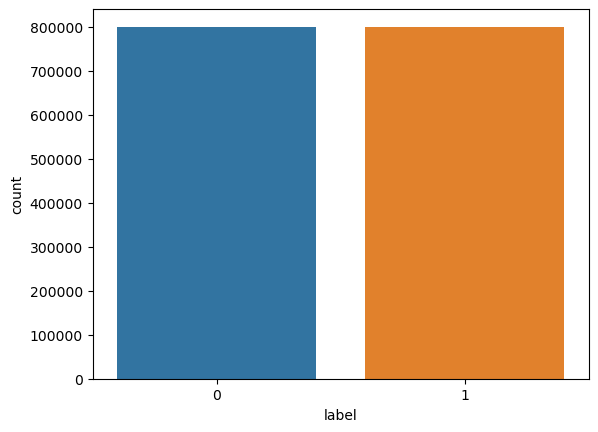

In [32]:
sns.countplot(x='label', data=df)

In [33]:
positive_tweets = list(df[df['label'] == 4]['text'])
negative_tweets = list(df[df['label'] == 0]['text'])

# Split the data

In [34]:
X,y = df.text, df.label

In [35]:
X_train , X_test, y_train , y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

# Text Preprocessing

In [36]:
def process_tweet(tweet):

    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    
    # remove hashtags(only removing the hash # )
    tweet = re.sub(r'#', '', tweet)
    
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and     # remove stopwords
                word not in string.punctuation):  # remove punctuation
            stem_word = stemmer.stem(word)        # stemming word
            tweets_clean.append(stem_word)

    return tweets_clean #a list of words containing the processed tweet

# Build frequencies

> create a function that will take tweets and their labels as input, go through every tweet, preprocess them, count the occurrence of every word in the data set and create a frequency dictionary

In [37]:
def build_freqs(tweets, label):

    # Convert np array to list since zip needs an iterable
    labelList = np.squeeze(label).tolist() # squeeze function is necessary or the list ends up with one element

    freqs = {}
    for y, tweet in zip(labelList, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs  #a dictionary mapping each (word, sentiment) pair to its frequency

In [38]:
print("Original Tweet - ")
print(X_train[10])
print("Processed Tweet - ")
print(process_tweet(X_train[10]))

Original Tweet - 
spring break in plain city... it's snowing 
Processed Tweet - 
['spring', 'break', 'plain', 'citi', '...', 'snow']


In [39]:
freqs = build_freqs(X_train, y_train)

# Model

# Activation function
Logistic regression makes use of the sigmoid function which outputs a probability between 0 and 1. 

In [40]:
def sigmoid(z):
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    # calculate the sigmoid of z
    h = 1/(1 + np.exp(-z))
    
    return h

# Optimization algorithm

> use StochasticGradientDescent due to large size of data

In [41]:
def StochasticGradientDescent(x, y, theta, alpha, num_iters, batch_per_itr, batch_size):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: final weight vector
        
    '''
    # get 'm', the number of rows in matrix x
    m =  x.shape[0]
    loss = []
    for itr in range(0, num_iters):
        
        for i in range(batch_per_itr):
            batch = np.random.randint(0, m, size=batch_size)
            x_train = x[batch,:]
            y_train = y[batch,:]
            
            # get z, the dot product of x and theta
            z = np.dot(x_train, theta)
        
            # get the sigmoid of z
            h = sigmoid(z)
        
            # calculate the cost function
            J = -1/batch_size * (np.dot(np.transpose(y_train),np.log(h)) + np.dot(np.transpose(1 - y_train), np.log(1 - h)))
            
            
        
            # update the weights theta
            theta = theta - ( alpha/m * np.dot(np.transpose(x_train), (h - y_train)))
        if not itr%10 and itr:
            print("Completed {} iterations, loss = {}".format(itr, np.squeeze(J))) 
        loss.append(J)
    J = float(J)
    return J, theta, loss

# Extract Features

In [42]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
    
    
    # loop through each word in the list of words
    for word in word_l:
        pos_pair = (word, 1.0)
        neg_pair = (word, 0.0)
        if pos_pair in freqs.keys():
            # increment the word count for the positive label 1
            x[0,1] += freqs[pos_pair]
        if neg_pair in freqs.keys():
            # increment the word count for the negative label 0
            x[0,2] += freqs[neg_pair]
        
        
    assert(x.shape == (1, 3))
    return x


In [44]:
# collect the features 'x' and stack them into a matrix 'X'
X = np.zeros((len(X_train), 3))
for i in range(len(X_train)):
    X[i, :]= extract_features(X_train[i], freqs)
    
# training labels corresponding to X
Y = y_train
Y = np.reshape(Y.values, (-1,1))

In [45]:
# shuffle data
s = np.random.permutation(range(len(X)))
X = X[s]
Y = Y[s]

# Training

In [46]:
J, theta, loss_logs = StochasticGradientDescent(X, Y, theta = np.zeros((3, 1)), alpha=1e-9, num_iters=100, batch_per_itr=50, batch_size=100000) 
print(f"The cost after traill ning is {J:.8f}.")
print(f"The resulting vector of weights is {[round(t, 8) for t in np.squeeze(theta)]}")

Completed 10 iterations, loss = 0.5963993171411567
Completed 20 iterations, loss = 0.5948641986359267
Completed 30 iterations, loss = 0.594303887270377
Completed 40 iterations, loss = 0.5946068487921305
Completed 50 iterations, loss = 0.5919068557583289
Completed 60 iterations, loss = 0.5914494639441912
Completed 70 iterations, loss = 0.5908262007422129
Completed 80 iterations, loss = 0.5933223514322455
Completed 90 iterations, loss = 0.5920252015326855
The cost after traill ning is 0.59489765.
The resulting vector of weights is [-2e-08, 6.062e-05, -3.447e-05]


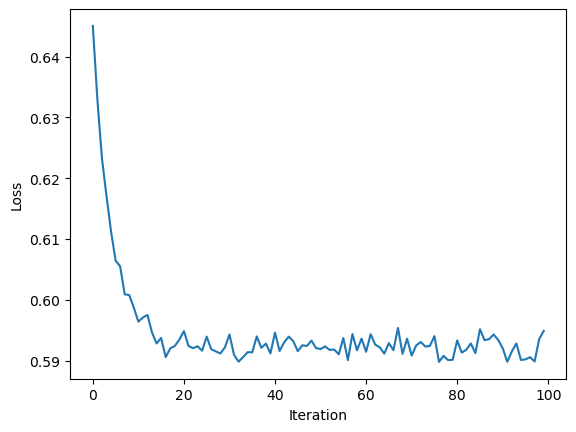

In [47]:
plt.plot(np.squeeze(loss_logs))
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# Prediction and Evaluation

In [48]:
def predict_tweet(tweet, freqs, theta):
    '''
    Input: 
        tweet: a string
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
        theta: (3,1) vector of weights
    Output: 
        y_pred: the probability of a tweet being positive or negative
    '''
    
    # extract the features of the tweet and store it into x
    x = extract_features(tweet, freqs)
    
    # make the prediction using x and theta
    z = np.dot(x,theta)
    y_pred = sigmoid(z)
    
    
    return y_pred

In [49]:
def test_logistic_regression(test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: a list of tweets
        test_y: (m, 1) vector with the corresponding labels for the list of tweets
        freqs: a dictionary with the frequency of each pair (or tuple)
        theta: weight vector of dimension (3, 1)
    Output: 
        accuracy: (# of tweets classified correctly) / (total # of tweets)
    """
        
    # the list for storing predictions
    y_hat = []
    
    for tweet in test_x:
        # get the label prediction for the tweet
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 to the list
            y_hat.append(1)
        else:
            # append 0 to the list
            y_hat.append(0)
            
# With the above implementation, y_hat is a list, but test_y is (m,1) array
    # convert both to one-dimensional arrays in order to compare them using the '==' operator
    y_hat = np.array(y_hat)
    test_y = test_y.reshape(-1)
    accuracy = np.sum((test_y == y_hat).astype(int))/len(test_x)
    
    return accuracy

In [50]:
tmp_accuracy = test_logistic_regression(X_test, np.reshape(y_test.values, (-1,1)), freqs, theta)
print(f"Logistic regression model's accuracy = {tmp_accuracy:.4f}")

Logistic regression model's accuracy = 0.5638
